In [1]:
# Finite Difference Method
import numpy as np
from scipy.sparse import diags
from tqdm import tqdm


K_R = 2.596 # (J/s*m*C) thermal conductivity of rock
U = 120 # (J/s*m^2*C) overall heat transfer coefficient between rock and water
A = 10**3*10**3 # (m^2) area for heat transfer between rock and water
m = 145 # (kg/s) mass flowrate of water
rho_W = 1000 # kg/m^3 density of water
c_W = 4184 # (J/kg*C) heat capacity of water
rho_R = 2650 # (kg/m^3) density of rock
c_R = 1050 # (J/kg*K) heat capacity of rock

t_final =  100 # (years) maximum amount of time
L = 40 # (m) maximum length of rock

T_W0 = 65 # (deg. C) initial water temperature
T_R0 = 300 # (deg. C) final rock temperature


t_final = 31536000 * t_final # time in seconds
dt = t_final/100
dx = L/100

w = m * c_W / U / A
kappa = K_R / rho_R / c_R
h = -U * A / K_R * (w / (w + 1/2))
s = kappa * dt / dx**2


# Backwards Euler Implicit Method
t_array = np.arange(0, t_final+dt, dt)
x_array = np.arange(0, L+dx, dx)

len_t = len(t_array)
len_x = len(x_array)

T = np.zeros([len_t, len_x]) # temperature matrix

# initial boundary condition
T[0,:] = T_R0 - T_W0


# backward implicit
for t in tqdm(range(0, len_t-1)):
    A = diags([-s, 1+2*s, -s], [-1, 0, 1], shape=(len_x, len_x)).toarray()
    B = T[t,:]
    
    # boundary condition on left side
    A[0,0] = A[0,0] - s * (1 + h*dx)
    
    # boundary condition on right side
    A[-1,-1] = A[-1,-1] - s
    
    T[t+1,:] = np.linalg.solve(A,B)

# add initial temperature of water
T = T + T_W0

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2482.56it/s]


In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact

@interact(t_=(0,t_final/31536000,t_final/31536000/100))
def plot(t_):
    time = int(t_*31536000/t_final*(len_t-1))
    plt.plot(
        x_array,
        T[time,:]
    )
    plt.ylim(T_W0,T_R0)
    plt.show()

interactive(children=(FloatSlider(value=50.0, description='t_', step=1.0), Output()), _dom_classes=('widget-in…

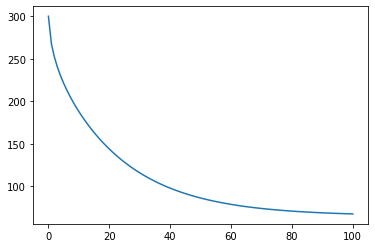

In [3]:
# plot average rock temperature over time
plt.plot(
    t_array/31536000,
    np.average(T,axis=1)
)

In [4]:
# Semi-Analytical Method

import numpy as np
from scipy.optimize import minimize_scalar
from math import tan, pi
from sympy import symbols, integrate, sin, cos
from sympy.functions import exp

x = symbols('x')
t = symbols('t')

f_x = T_R0 - T_W0 # 100*(1-x/3)

def MSE_mu(mu, h, L):
    """
    Mean squared error between
    -mu/h and cot(mu*L)
    """
    linear = -mu/h
    nonlinear = 1/tan(mu*L) # cotangent
    MSE = (linear - nonlinear)**2
    return MSE


# generate table of equations
num_constants = 10
equation = 0

for num_index in range(num_constants):
    ### mu_n
    n = num_index + 1
    left_bound = pi*(n - 1)/L
    right_bound = pi*(n)/L
    answer = minimize_scalar(MSE_mu, 
                             method='bounded', 
                             bounds=(left_bound, right_bound), 
                             args=(h, L))
    mu_n = answer.x
    
    
    ### A_n
    top = f_x * (sin(mu_n*x)-mu_n/h*cos(mu_n*x))
    top = integrate(top, (x, L, 0))
    
    bottom = (sin(mu_n*x)-mu_n/h*cos(mu_n*x))**2
    bottom = integrate(bottom, (x, L, 0))
    
    A_n = top/bottom
    
    
    ### lambda_n
    exponent = -mu_n**2 * kappa * t
    
    
    ### equation
    X_n = A_n*(sin(mu_n*x)-mu_n/h*cos(mu_n*x))
    T_n = exp(exponent)
    equation += X_n*T_n

# add initial water temperature
equation += T_W0

# show equation
equation

(299.211289920126*sin(0.039269906993858*x) + 2.53934732968718e-5*cos(0.039269906993858*x))*exp(-1.43876299925069e-9*t) + (99.7370815488355*sin(0.117809720981574*x) + 2.53934694545887e-5*cos(0.117809720981574*x))*exp(-1.29488669932562e-8*t) + (59.8422670387347*sin(0.196349534969289*x) + 2.53934771391485e-5*cos(0.196349534969289*x))*exp(-3.5969074981267e-8*t) + (42.744457053262*sin(0.274889348957004*x) + 2.53934656123012e-5*cos(0.274889348957004*x))*exp(-7.0499386963283e-8*t) + (33.2457089407928*sin(0.353429162944719*x) + 2.5393480981418e-5*cos(0.353429162944719*x))*exp(-1.16539802939304e-7*t) + (27.2010140090101*sin(0.431968976932434*x) + 2.53934617700093e-5*cos(0.431968976932434*x))*exp(-1.7409032290933e-7*t) + (23.0162635185009*sin(0.510508790920148*x) + 2.53934848236803e-5*cos(0.510508790920148*x))*exp(-2.43150946873361e-7*t) + (19.9474072550222*sin(0.589048604907861*x) + 2.53934579277128e-5*cos(0.589048604907861*x))*exp(-3.23721674831396e-7*t) + (17.6006747655179*sin(0.6675884188955

In [5]:
@interact(time=(0,t_final/31536000, t_final/31536000/1000))
def plot(time):
    x_range = np.arange(0, L, L/100)
    plt.plot(
        x_range,
        [equation.subs({'x':i, 't':time*31536000}) for i in x_range]
    )
    plt.ylim(T_W0,T_R0)
    plt.show()

interactive(children=(FloatSlider(value=50.0, description='time'), Output()), _dom_classes=('widget-interact',…

In [112]:
# Error between analytical and numerical solution

@interact(t_=(0,t_final/31536000, t_final/31536000/100))
def plot(t_):
    # analytical
    T_analytical = [equation.subs({'x':i, 't':t_*31536000}) for i in x_array]
    
    # numerical
    time = int(t_*31536000/t_final*(len_t-1))
    T_numerical = T[time,:]
    
    # difference
    T_difference = T_analytical - T_numerical
    
    plt.plot(
        x_array,
        T_difference
    )
    plt.show()

interactive(children=(FloatSlider(value=50.0, description='t_', step=1.0), Output()), _dom_classes=('widget-in…

In [113]:
# plot difference between average temperatures between analytical and finite difference method
water_temp_diff = []

for times in tqdm(np.arange(0,31536000, 31536000/100)):
    T_analytical = [equation.subs({'x':i, 't':times}) for i in x_array]
    
    time = int(times/t_final*(len_t-1))
    T_numerical = T[time,:]
    
    avg_T_analytical = sum(T_analytical)/len(T_analytical)
    avg_T_numerical = sum(T_numerical)/len(T_numerical)
    
    water_temp_diff.append(avg_T_analytical - avg_T_numerical)

100%|█████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


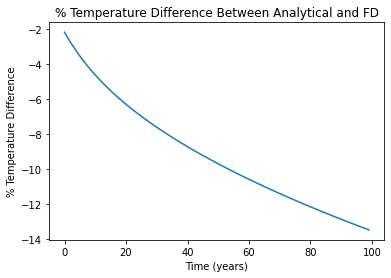

In [26]:
plt.plot(
    t_array[:-1]/31536000,
    np.array(water_temp_diff)/T_R0*100
)
plt.title('% Temperature Difference Between Analytical and FD')
plt.xlabel('Time (years)')
plt.ylabel('% Temperature Difference')
plt.show()

In [63]:
# plot nondimensionalized equation

def make_nondimensional_equation(h, L):
    global T_W0, f_x
    equation = 0

    for num_index in range(num_constants):
        ### mu_n
        n = num_index + 1
        left_bound = pi*(n - 1)/L
        right_bound = pi*(n)/L
        answer = minimize_scalar(MSE_mu, 
                                 method='bounded', 
                                 bounds=(left_bound, right_bound), 
                                 args=(h, L))
        mu_n = answer.x


        ### A_n
        top = f_x * (sin(mu_n*x)-mu_n/h*cos(mu_n*x))
        top = integrate(top, (x, L, 0))

        bottom = (sin(mu_n*x)-mu_n/h*cos(mu_n*x))**2
        bottom = integrate(bottom, (x, L, 0))

        A_n = top/bottom


        ### lambda_n
        exponent = -mu_n**2 * kappa * t


        ### equation
        X_n = A_n*(sin(mu_n*x)-mu_n/h*cos(mu_n*x))
        T_n = exp(exponent)
        equation += X_n*T_n

    # add initial water temperature
    equation += T_W0

    # show equation
    return equation

In [88]:
eq_1 = make_nondimensional_equation(h=-.1 , L=40)
eq_2 = make_nondimensional_equation(h=-1 ,L=40)
eq_3 = make_nondimensional_equation(h=-10,L=40)

Text(0, 0.5, 'Dimensionless Temperature')

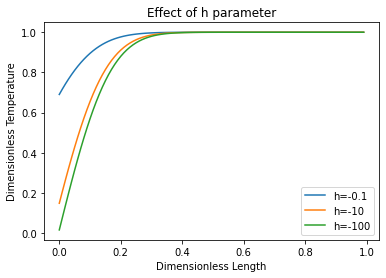

In [89]:
theta = 80000000*31536000/(L**2/(pi**2*kappa))
nondimensional_x_array = np.arange(0,1,1/100)
plt.plot(
    nondimensional_x_array,
    (np.array([
        [eq_1.subs({'x':i*L, 't':theta}) for i in nondimensional_x_array],
        [eq_2.subs({'x':i*L, 't':theta}) for i in nondimensional_x_array],
        [eq_3.subs({'x':i*L, 't':theta}) for i in nondimensional_x_array],
    ]).T - T_W0)/(T_R0-T_W0),
)
plt.legend(
[
    'h=-0.1',
    'h=-10',
    'h=-100',
])
plt.title('Effect of h parameter')
plt.xlabel('Dimensionless Length')
plt.ylabel('Dimensionless Temperature')

In [92]:
eq_1 = make_nondimensional_equation(h=h, L=20)
eq_2 = make_nondimensional_equation(h=h ,L=80)
eq_3 = make_nondimensional_equation(h=h ,L=110)

Text(0, 0.5, 'Dimensionless Temperature')

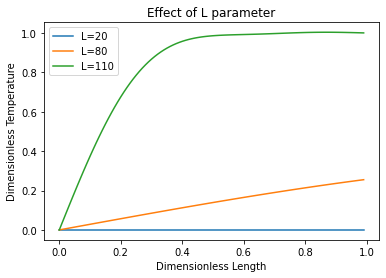

In [95]:
nondimensional_x_array = np.arange(0,1,1/100)
plt.plot(
    nondimensional_x_array,
    (np.array([
        [eq_1.subs({'x':i*L, 't':1200000000*31536000/(1**2/(pi**2*kappa))}) for i in nondimensional_x_array],
        [eq_2.subs({'x':i*L, 't':1200000000*31536000/(10**2/(pi**2*kappa))}) for i in nondimensional_x_array],
        [eq_3.subs({'x':i*L, 't':1200000000*31536000/(100**2/(pi**2*kappa))}) for i in nondimensional_x_array],
    ]).T - T_W0)/(T_R0-T_W0),
)
plt.legend(
[
    'L=20',
    'L=80',
    'L=110',
])
plt.title('Effect of L parameter')
plt.xlabel('Dimensionless Length')
plt.ylabel('Dimensionless Temperature')

Text(0, 0.5, 'h')

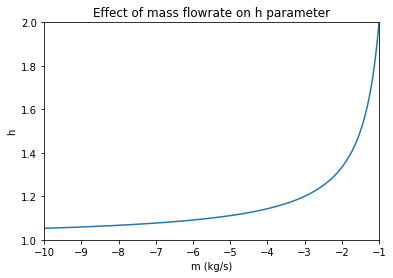

In [106]:
plt.plot(
    [i for i in np.arange(-10,0,1/100)],
    np.array([i/(i+1/2) for i in np.arange(-10,0,1/100)])
)
plt.ylim(1,2)
plt.xlim(-10,-1)
plt.title('Effect of mass flowrate on h parameter')
plt.xlabel('m (kg/s)')
plt.ylabel('h')

In [6]:
# plot regular equation
def make_equation(L, K_R, m):
    A = 10**6
    
    w = m * c_W / U / A
    kappa = K_R / rho_R / c_R
    h = -U * A / K_R * (w / (w + 1/2))
    
    equation = 0

    for num_index in range(num_constants):
        ### mu_n
        n = num_index + 1
        left_bound = pi*(n - 1)/L
        right_bound = pi*(n)/L
        answer = minimize_scalar(MSE_mu, 
                                 method='bounded', 
                                 bounds=(left_bound, right_bound), 
                                 args=(h, L))
        mu_n = answer.x


        ### A_n
        top = f_x * (sin(mu_n*x)-mu_n/h*cos(mu_n*x))
        top = integrate(top, (x, L, 0))

        bottom = (sin(mu_n*x)-mu_n/h*cos(mu_n*x))**2
        bottom = integrate(bottom, (x, L, 0))

        A_n = top/bottom


        ### lambda_n
        exponent = -mu_n**2 * kappa * t


        ### equation
        X_n = A_n*(sin(mu_n*x)-mu_n/h*cos(mu_n*x))
        T_n = exp(exponent)
        equation += X_n*T_n

    # add initial water temperature
    equation += T_W0

    # show equation
    return equation

In [15]:
eq_1 = make_equation(L=4, K_R=K_R, m=m)
eq_2 = make_equation(L=40, K_R=K_R, m=m)
eq_3 = make_equation(L=110, K_R=K_R, m=m)

Text(0, 0.5, 'Temperature (°C)')

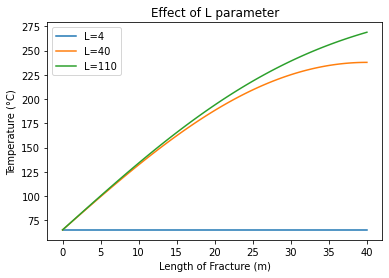

In [19]:
time = 12 * 31536000
plt.plot(
    x_array,
    np.array([
        [eq_1.subs({'x':i, 't':time}) for i in x_array],
        [eq_2.subs({'x':i, 't':time}) for i in x_array],
        [eq_3.subs({'x':i, 't':time}) for i in x_array],
    ]).T,
)
plt.legend(
[
    'L=4',
    'L=40',
    'L=110',
])
plt.title('Effect of L parameter')
plt.xlabel('Length of Fracture (m)')
plt.ylabel('Temperature (°C)')

In [20]:
eq_1 = make_equation(L=L, K_R=K_R*.1, m=m)
eq_2 = make_equation(L=L, K_R=K_R, m=m)
eq_3 = make_equation(L=L, K_R=K_R*10, m=m)

Text(0, 0.5, 'Temperature (°C)')

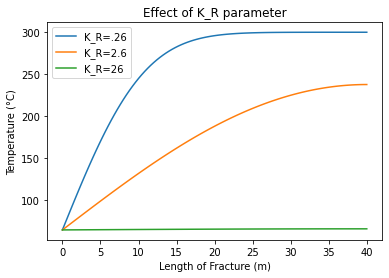

In [25]:
time = 12 * 31536000
plt.plot(
    x_array,
    np.array([
        [eq_1.subs({'x':i, 't':time}) for i in x_array],
        [eq_2.subs({'x':i, 't':time}) for i in x_array],
        [eq_3.subs({'x':i, 't':time}) for i in x_array],
    ]).T,
)
plt.legend(
[
    'K_R=.26',
    'K_R=2.6',
    'K_R=26',
])
plt.title('Effect of K_R parameter')
plt.xlabel('Length of Fracture (m)')
plt.ylabel('Temperature (°C)')

In [26]:
eq_1 = make_equation(L=L, K_R=K_R, m=m*0.1)
eq_2 = make_equation(L=L, K_R=K_R, m=m)
eq_3 = make_equation(L=L, K_R=K_R, m=m*10)

Text(0, 0.5, 'Temperature (°C)')

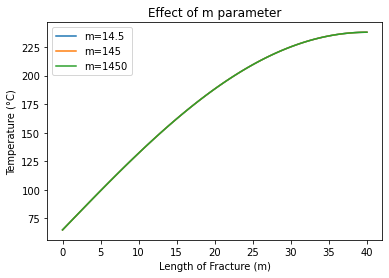

In [31]:
time = 12 * 31536000
plt.plot(
    x_array,
    np.array([
        [eq_1.subs({'x':i, 't':time}) for i in x_array],
        [eq_2.subs({'x':i, 't':time}) for i in x_array],
        [eq_3.subs({'x':i, 't':time}) for i in x_array],
    ]).T,
)
plt.legend(
[
    'm=14.5',
    'm=145',
    'm=1450',
])
plt.title('Effect of m parameter')
plt.xlabel('Length of Fracture (m)')
plt.ylabel('Temperature (°C)')

In [29]:
print(
m/10,
m,
m*10)

14.5 145 1450
